In [260]:
import librosa
import numpy as np
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

## Training YamNet based classifier
* ### Yamnet taken 1D array as input, processes 0.96s at one go
* ### Output embedding size of audio is 1024 dimension
* ### Two Dense layers added after YamNet to classify audio in 3 categories

In [7]:
basepath = Path.cwd()/'datasets'

In [91]:
def compile_filenames(basepath, category_dict):
    """
    Make list of tuple (filename, category) in basepath
    Args:
        basepath(path): path of the dataset
        categorydict(dict): key - category, value - class label
    Returns:
        list[tuple]: list of tuple (filename, classlabel)
    """
    filenames = list()
    labels = list()
    for cat in category_dict.keys():
        
        path = basepath/cat
        label = category_dict[cat]
        for file in path.iterdir():
            filenames.append(str(file))
            labels.append(label)
      
        
    return filenames, labels

def audio_to_numpy(filename, duration = 5, sr = 16000):
    """
    Sample the audio file using 16KHz for 5 second
    Then break it in 10000 samples, i.e. total 8 frames
    Example - Audio is 5 sec long, i.e 80000 sample.
              Total 8 frames will be generated (last frame will be ignored) 
    """
    filename = filename.numpy().decode('utf-8')
    y, _ = librosa.load(filename, sr=sr, duration = duration)
    y = np.pad(y, pad_width=(0,duration*sr - y.shape[0]),mode='constant', constant_values = (0,0))
    return y

def one_hot(label, n=10):
    """
    Convert label to one hot vector
    """
    val = label.numpy()
    val = np.full(n, fill_value=val)
    val = tf.one_hot(val, 3)
    return val

def convert_audio(filename, label):
    """
    Reads file from disk and convert to time series data.
    Args:
        filename(path): path of audio file
        label(int): class label of audio file
    Returns:
        np.ndarray: numpy array of 1D having values (0,1)
    Remarks:
        The sr is 16000 and time 5 second max
        The shape of the output is (80000,)
        Zero padding will be done if audio is not 5 sec.
    """
    X = tf.py_function(audio_to_numpy, [filename], tf.float32)
    labels = tf.py_function(one_hot, [label], tf.float32)
    # print(labels)
    return X, labels


In [93]:
category_dict = {'normal':0, 'cry':1, 'scream':2}
filenames, labels = compile_filenames(basepath, category_dict)

In [109]:
train_files, test_files, train_labels, test_labels = train_test_split(
    filenames, labels, stratify=labels, test_size=0.3, shuffle=True
)
val_files, test_files, val_labels, test_labels = train_test_split(
    test_files, test_labels, stratify=test_labels, test_size=0.5, shuffle=True
)

In [111]:
train_data = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_data = train_data.map(convert_audio)
val_data = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_data = val_data.map(convert_audio)
test_data = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_data = test_data.map(convert_audio)

## Finetune YamNet model

In [216]:
# Model Building
class YamNetLayer(tf.keras.Layer):
    def __init__(self):
        super().__init__()
        yamnet_model_handle = 'https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1'
        self.yamnet_model = hub.KerasLayer(yamnet_model_handle, trainable=False)
    def call(self, x):
        y = self.yamnet_model(x)[1]
        return y

audio_ip = tf.keras.Input(shape=())
embeddings = YamNetLayer()(audio_ip)
y = tf.keras.layers.Dense(512, activation='relu')(embeddings)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(3, activation='softmax')(y)
model = tf.keras.Model(inputs = audio_ip, outputs = y)

In [217]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ yam_net_layer_3 (YamNetLayer)   │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,339 (2.01 MB)

 Trainable params: 526,339 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [218]:
def measure_accuracy(model, x, y):
    """
    Here x is 1D vector and y is true label.
    Model may generate (K, c) output for K frames and c classes
    Calculate how many frames are correctly classified
    """
    with tf.device("/cpu:0"):
        y_pred = model(x)
    n = y_pred.shape[0]
    y_pred = np.argmax(y_pred, axis=1)
    correct = sum(y_pred == y)
    return correct, correct/n

In [211]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy'])

In [231]:
# Training Loop
EPOCHS = 5
loss_fun = tf.keras.losses.CategoricalCrossentropy()
optim = tf.keras.optimizers.Adam()
tr_losses = list()
tr_acc = list()
val_acc = list()
val_losses = list()

for epoch in range(EPOCHS):
    training_correct = 0
    training_loss = list()
    val_loss = list()
    val_correct = 0
    
    for j, (X, y) in enumerate(train_data):
        with tf.device("/cpu:0"):
            with tf.GradientTape() as tap:
                y_pred = model(X)
                loss = loss_fun(y, y_pred)

            grad = tap.gradient(loss, model.trainable_variables)
            optim.apply_gradients(zip(grad, model.trainable_variables))

            correct, acc = measure_accuracy(model, X, np.argmax(y[0]))
            training_correct += correct
            training_loss.append(loss.numpy())

            if (j+1) % 100 == 0:
                print(f"Training -Epoch -{epoch},step - {j}| loss = {loss.numpy()} | acuracy = {acc}")
    
    training_acc = training_correct/ (len(train_data)*10)
    # training_acc = training_correct/ (50*10)
    tr_acc.append(training_acc)
    tr_losses.append(np.mean(training_loss))


    # validation after epoch
    for i, (X, y) in enumerate(val_data):
        with tf.device("/cpu:0"):
            y_pred = model(X)
        loss = loss_fun(y, y_pred)
        correct, acc = measure_accuracy(model, X, np.argmax(y[0]))
        val_correct += correct
        val_loss.append(loss.numpy())

    validation_acc = val_correct/ (len(val_data)*10)
    # validation_acc = val_correct/ (50*10)
    val_acc.append(validation_acc)
    val_losses.append(np.mean(val_loss))

    print(f"End of epoch {epoch+1}\n")
    print(f"Trainig: loss = {tr_losses[-1]}, accuracy = {tr_acc[-1]}")
    print(f"Validation: loss = {val_losses[-1]}, accuracy = {val_acc[-1]}")

with open("yamnet.pkl", "wb") as f:
    pickle.dump(model, f)
    f.close()

Training -Epoch -0,step - 99| loss = 0.001518299337476492 | acuracy = 1.0
Training -Epoch -0,step - 199| loss = 0.0035102595575153828 | acuracy = 1.0
Training -Epoch -0,step - 299| loss = 3.788952381000854e-05 | acuracy = 1.0
Training -Epoch -0,step - 399| loss = 0.12086929380893707 | acuracy = 1.0
Training -Epoch -0,step - 499| loss = 0.015964999794960022 | acuracy = 1.0
Training -Epoch -0,step - 599| loss = 0.1242590993642807 | acuracy = 1.0
Training -Epoch -0,step - 699| loss = 2.98018790090282e-06 | acuracy = 1.0
Training -Epoch -0,step - 799| loss = 2.6636674404144287 | acuracy = 0.2
Training -Epoch -0,step - 899| loss = 0.0074170371517539024 | acuracy = 1.0
Training -Epoch -0,step - 999| loss = 0.324531227350235 | acuracy = 0.9
Training -Epoch -0,step - 1099| loss = 0.05365511029958725 | acuracy = 1.0
Training -Epoch -0,step - 1199| loss = 0.10595744848251343 | acuracy = 1.0
Training -Epoch -0,step - 1299| loss = 0.0001805221982067451 | acuracy = 1.0
Training -Epoch -0,step - 139

2025-02-24 13:15:07.310037: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End of epoch 1

Trainig: loss = 0.400648832321167, accuracy = 0.9288715486194478
Validation: loss = 0.27564698457717896, accuracy = 0.9081232492997199
Training -Epoch -1,step - 99| loss = 0.0035262037999927998 | acuracy = 1.0
Training -Epoch -1,step - 199| loss = 0.0051347436383366585 | acuracy = 1.0
Training -Epoch -1,step - 299| loss = 5.3070012654643506e-05 | acuracy = 1.0
Training -Epoch -1,step - 399| loss = 0.07865722477436066 | acuracy = 1.0
Training -Epoch -1,step - 499| loss = 0.02117781899869442 | acuracy = 1.0
Training -Epoch -1,step - 599| loss = 0.14462420344352722 | acuracy = 1.0
Training -Epoch -1,step - 699| loss = 1.966933950825478e-06 | acuracy = 1.0
Training -Epoch -1,step - 799| loss = 2.5490071773529053 | acuracy = 0.3
Training -Epoch -1,step - 899| loss = 0.005810920149087906 | acuracy = 1.0
Training -Epoch -1,step - 999| loss = 0.2863817811012268 | acuracy = 1.0
Training -Epoch -1,step - 1099| loss = 0.04418470710515976 | acuracy = 1.0
Training -Epoch -1,step - 1

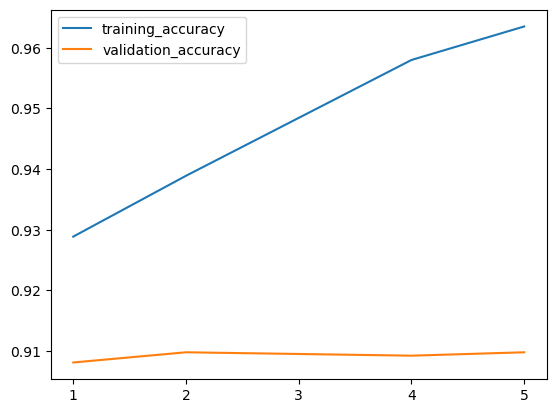

In [243]:
plt.plot(range(1,6), tr_acc, label='training_accuracy')
plt.plot(range(1,6),val_acc, label = 'validation_accuracy')
plt.xticks(range(1,6))
plt.legend()
plt.show()

## Peformance on Test Data

In [253]:
test_true = list()
test_pred = list()
for X,y in test_data:
    with tf.device("/cpu:0"):
        y_pred = model(X)
    n = y_pred.shape[0]
    true_label = np.argmax(y[0])
    test_true = test_true + [true_label]*n
    y_pred = np.argmax(y_pred, axis=1)
    test_pred = test_pred + list(y_pred)

In [264]:
acc = accuracy_score(test_true, test_pred)
print(f"Test accuracy is {acc}")

Test accuracy is 0.8958100558659218


In [268]:
cm  = confusion_matrix(test_true, test_pred)
cm

array([[1479,    8,   23],
       [  16,  696,   58],
       [ 116,  152, 1032]])

In [270]:
# precision matrix
col_sum = np.sum(cm, axis=0, keepdims=True)
prec_mat = cm/col_sum
prec_mat

array([[0.91806331, 0.00934579, 0.02066487],
       [0.00993172, 0.81308411, 0.05211141],
       [0.07200497, 0.17757009, 0.92722372]])

In [272]:
# recall matrix
row_sum = np.sum(cm, axis=1, keepdims=True)
rec_mat = cm/row_sum
rec_mat

array([[0.9794702 , 0.00529801, 0.01523179],
       [0.02077922, 0.9038961 , 0.07532468],
       [0.08923077, 0.11692308, 0.79384615]])